In [22]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pymongo as pm
conn = pm.MongoClient(port=27016)
import gridfs
import _pickle as cPickle
from scipy.stats import pearsonr

In [24]:
def return_metrics(dbname='deepretina', collname='whitenoise', exp_id='trainval1'):
    if '.files' not in collname:
        coll = conn[dbname][collname+'.files']
    else:
        coll = conn[dbname][collname]    

    train_metrics = [r['validation_results']['train_loss']['poisson_loss'] for r in coll.find({'exp_id': exp_id,
                                                        'validation_results': {'$exists': True}}).sort('step')]
    
    val_metrics = [r['validation_results']['test_loss']['poisson_loss'] for r in coll.find({'exp_id': exp_id,
                                                        'validation_results': {'$exists': True}}).sort('step')]
    return train_metrics, val_metrics

def plot_trainval(dbname='deepretina', collname='whitenoise', exp_id='trainval1', save_valid_freq=200, ylim=None):
    train_metrics, test_metrics = return_metrics(dbname=dbname, collname=collname, exp_id=exp_id)
    save_valid_freq = save_valid_freq
    num_iters = save_valid_freq*(len(train_metrics))
    x = np.arange(0, num_iters, step=save_valid_freq)
    plt.plot(x, train_metrics, color='r', label="train loss", linewidth=4.0)
    plt.plot(x, test_metrics, color='b', label="test loss", linewidth=4.0)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def load_from_gridfs(conn=conn, dbname='deepretina', collname='whitenoise', expid_prefix='trainval1', load_step=None, file=0):
    if load_step is None:
        load_stepstr = 'recent'
    else:
        load_stepstr = str(load_step)
    expidstr = expid_prefix+'_step'+load_stepstr
    r = conn[dbname][collname+'.files'].find_one({'exp_id': expidstr, 'step': file})
    _id = r['_id']
    fn = str(_id) + '_fileitems'
    fsys = gridfs.GridFS(conn[dbname], collname)
    fh = fsys.get_last_version(fn)
    fstr = fh.read()
    fh.close()
    obj = cPickle.loads(fstr, encoding='latin1')
    pred_resp = np.array(obj['validation_results'][expid_prefix]['pred_resp'])
    gt_resp = np.squeeze(np.array(obj['validation_results'][expid_prefix]['gt_resp']))
    return pred_resp, gt_resp

def correlation_coefficient(obs_rate, est_rate):
    """Pearson correlation coefficient"""
    x_mu = obs_rate - np.mean(obs_rate, axis=0, keepdims=True)
    x_std = np.std(obs_rate, axis=0, keepdims=True)
    y_mu = est_rate - np.mean(est_rate, axis=0, keepdims=True)
    y_std = np.std(est_rate, axis=0, keepdims=True)
    return np.mean(x_mu * y_mu, axis=0, keepdims=True) / (x_std * y_std)

# Train on whitenoise

# Adam 1e-3 (best)

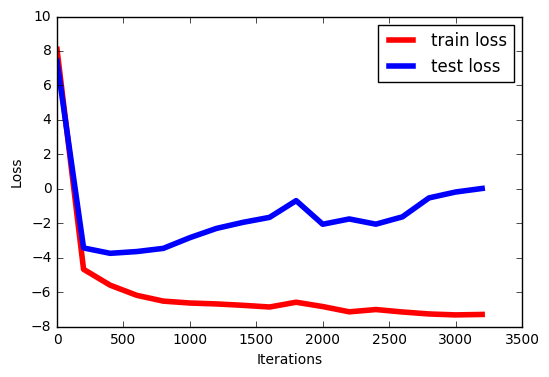

In [7]:
plot_trainval(dbname='deepretina', collname='whitenoise', exp_id='trainval1', save_valid_freq=200)

In [8]:
train, val = return_metrics(dbname='deepretina', collname='whitenoise', exp_id='trainval1')
print(200*np.argmin(val))
print(np.amin(val))

400
-3.75083732605


In [34]:
pred_resp, gt_resp = load_from_gridfs(conn=conn, dbname='deepretina', collname='whitenoise', expid_prefix='wnte0', load_step=400, file=0)

In [35]:
correlation_coefficient(gt_resp, pred_resp)

array([[ 0.65277636,  0.51945215,  0.49757251,  0.65405971,  0.48299935]], dtype=float32)

# Adam 1e-4

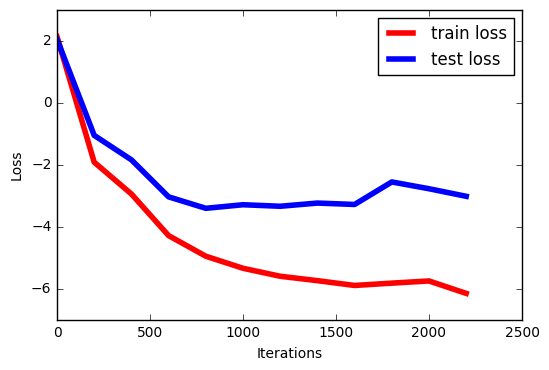

In [37]:
plot_trainval(dbname='deepretina', collname='whitenoise', exp_id='trainval2', save_valid_freq=200)

In [38]:
train, val = return_metrics(dbname='deepretina', collname='whitenoise', exp_id='trainval2')
print(200*np.argmin(val))
print(np.amin(val))

800
-3.41296219826


In [39]:
pred_resp, gt_resp = load_from_gridfs(conn=conn, dbname='deepretina', collname='whitenoise', expid_prefix='wnte2', load_step=800, file=0)
correlation_coefficient(gt_resp, pred_resp)

array([[ 0.53264487,  0.45865583,  0.43705156,  0.59954429,  0.43829387]], dtype=float32)

# Train on natural scene

# Adam lr 1e-3

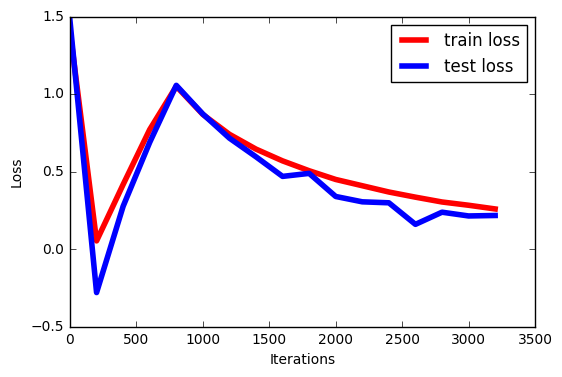

In [9]:
plot_trainval(dbname='deepretina', collname='naturalscene', exp_id='trainval0', save_valid_freq=200)

In [13]:
train, val = return_metrics(dbname='deepretina', collname='naturalscene', exp_id='trainval0')
print(200*np.argmin(val))
print(np.amin(val))

200
-0.281067162752


In [36]:
pred_resp, gt_resp = load_from_gridfs(conn=conn, dbname='deepretina', collname='naturalscene', expid_prefix='nste1', load_step=200, file=0)
correlation_coefficient(gt_resp, pred_resp)

array([[ 0.28376409,  0.20277993,  0.2538186 ,  0.28008693,  0.41566983]], dtype=float32)

# Adam lr 1e-4 (best)

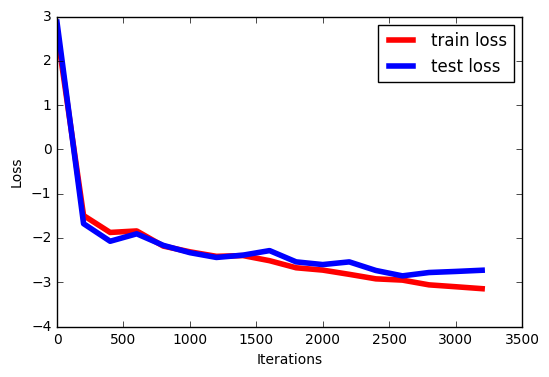

In [10]:
plot_trainval(dbname='deepretina', collname='naturalscene', exp_id='trainval1', save_valid_freq=200)

In [12]:
train, val = return_metrics(dbname='deepretina', collname='naturalscene', exp_id='trainval1')
print(200*np.argmin(val))
print(np.amin(val))

2600
-2.85663795471


In [32]:
pred_resp, gt_resp = load_from_gridfs(conn=conn, dbname='deepretina', collname='naturalscene', expid_prefix='nste0', load_step=2600, file=0)

In [33]:
correlation_coefficient(gt_resp, pred_resp)

array([[ 0.61670285,  0.43288532,  0.47567561,  0.5861153 ,  0.70803255]], dtype=float32)